In [60]:
# %pip install tensorflow
%pip install tensorflow==2.10.0 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:
# from google.colab import files
# uploaded = files.upload()

import pandas as pd
df = pd.read_csv('substation_data_Ch.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])


In [62]:
df.isna().sum()

timestamp               0
demand_kw              10
voltage_a               5
voltage_b               5
voltage_c               5
temperature_celsius    38
humidity_percent       28
dtype: int64

In [63]:
# doing forward fill and backword fill for safety
for col in ['voltage_a', 'voltage_b', 'voltage_c']:
    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
df = df.dropna(subset=['demand_kw', 'voltage_a', 'voltage_b', 'voltage_c', 'temperature_celsius', 'humidity_percent'])

# basic feature engineering
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['voltage_mean'] = df[['voltage_a', 'voltage_b', 'voltage_c']].mean(axis=1)


df = df.drop(columns=['voltage_a', 'voltage_b', 'voltage_c'])

# now feature
features = ['demand_kw', 'temperature_celsius', 'humidity_percent', 'voltage_mean', 'hour', 'weekday', 'is_weekend']


C:\Users\nafeu\AppData\Local\Temp\ipykernel_10168\993643396.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


In [64]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

# print(df.head())

In [65]:
import numpy as np

def create_sequences(data, target_col, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values)
        y.append(data.iloc[i+seq_length][target_col])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target_col='demand_kw', seq_length=24)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


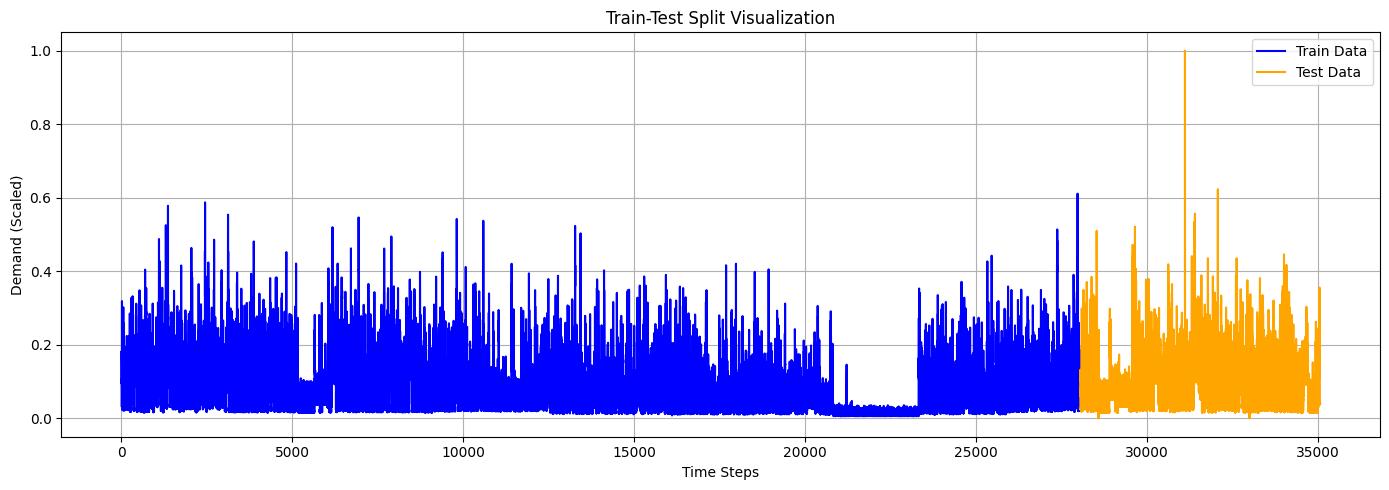

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(range(len(y_train)), y_train, label='Train Data', color='blue')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test Data', color='orange')
plt.title("Train-Test Split Visualization")
plt.xlabel("Time Steps")
plt.ylabel("Demand (Scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

def build_gru_model(units=64, layers=1, dropout=0.2):
    model = Sequential()
    for i in range(layers):
        return_seq = i < layers - 1
        model.add(GRU(units=units, return_sequences=return_seq, dropout=dropout, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))  
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_gru_model()
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
395/395 [==============================] - 18s 37ms/step - loss: 0.0029 - mae: 0.0362 - val_loss: 0.0023 - val_mae: 0.0304
Epoch 2/10
395/395 [==============================] - 17s 42ms/step - loss: 0.0024 - mae: 0.0329 - val_loss: 0.0023 - val_mae: 0.0302
Epoch 3/10
395/395 [==============================] - 15s 38ms/step - loss: 0.0023 - mae: 0.0326 - val_loss: 0.0023 - val_mae: 0.0302
Epoch 4/10
395/395 [==============================] - 15s 38ms/step - loss: 0.0023 - mae: 0.0324 - val_loss: 0.0021 - val_mae: 0.0320
Epoch 5/10
395/395 [==============================] - 18s 46ms/step - loss: 0.0023 - mae: 0.0321 - val_loss: 0.0021 - val_mae: 0.0329
Epoch 6/10
395/395 [==============================] - 18s 45ms/step - loss: 0.0023 - mae: 0.0322 - val_loss: 0.0021 - val_mae: 0.0311
Epoch 7/10
395/395 [==============================] - 18s 47ms/step - loss: 0.0022 - mae: 0.0315 - val_loss: 0.0023 - val_mae: 0.0352
Epoch 8/10
395/395 [==============================] - 18s 47ms

220/220 [==============================] - 2s 7ms/step


GRU Model Evaluation:
MAE      : 0.4251
RMSE     : 0.6543
R squared : 0.6228


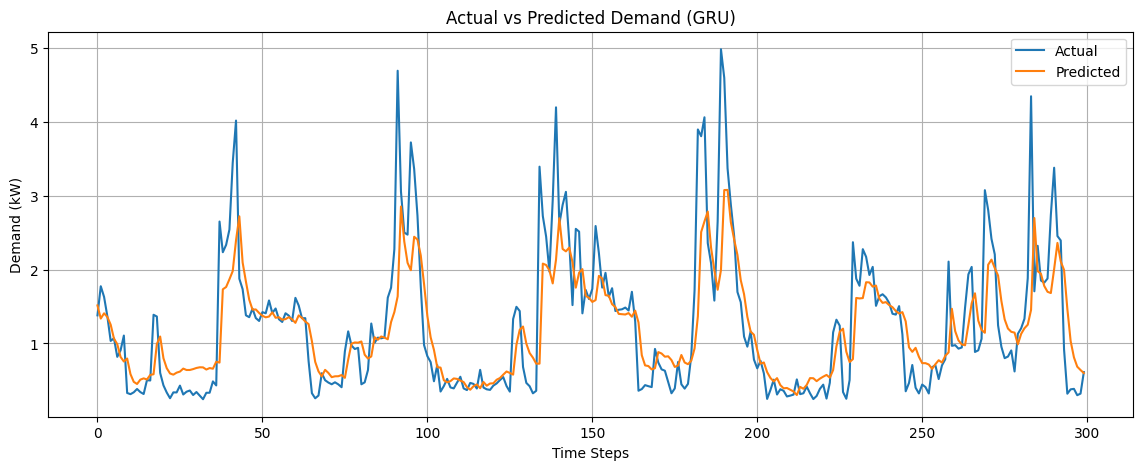

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test) 
y_pred_inv = scaler.inverse_transform(np.hstack((y_pred, X_test[:, -1, 1:])))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), X_test[:, -1, 1:])))[:, 0]

mae_gru = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_gru = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2_gru = r2_score(y_test_inv, y_pred_inv)

print("GRU Model Evaluation:")
print(f"MAE      : {mae_gru:.4f}")
print(f"RMSE     : {rmse_gru:.4f}")
print(f"R squared : {r2_gru:.4f}")

plt.figure(figsize=(14, 5))
plt.plot(y_test_inv[:300], label='Actual')
plt.plot(y_pred_inv[:300], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Demand (GRU)")
plt.xlabel("Time Steps")
plt.ylabel("Demand (kW)")
plt.grid(True)
plt.show()


In [70]:
# !pip install keras-tuner --quiet

import keras_tuner as kt


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()

    for i in range(hp.Int("num_layers", 1, 2)):  
        return_seq = i < hp.Int("num_layers", 1, 2) - 1
        model.add(GRU(
            units=hp.Int("units_" + str(i), min_value=32, max_value=128, step=32),
            return_sequences=return_seq,
            dropout=hp.Float("dropout_" + str(i), min_value=0.0, max_value=0.3, step=0.1),
            input_shape=(X_train.shape[1], X_train.shape[2])
        ))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling="log")),
        loss="mse",
        metrics=["mae"]
    )
    return model


In [72]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='gru_tuner_dir',
    project_name='gru_forecast'
)


In [73]:
tuner.search(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    verbose=2
)


Trial 10 Complete [00h 01m 39s]
val_loss: 0.001692855847068131

Best val_loss So Far: 0.0016868779202923179
Total elapsed time: 00h 49m 38s


In [74]:
best_model = tuner.get_best_models(num_models=1)[0]
best_params = tuner.get_best_hyperparameters(1)[0]
print("found best  hyperparameters:")
print(best_params.values)

y_pred_scaled = best_model.predict(X_test)

y_pred_inv = scaler.inverse_transform(np.hstack((y_pred_scaled, X_test[:, -1, 1:])))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), X_test[:, -1, 1:])))[:, 0]

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print("Tuned GRU model evaluation on test data")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R squared  : {r2:.4f}")



found best  hyperparameters:
{'num_layers': 1, 'units_0': 64, 'dropout_0': 0.0, 'lr': 0.0055855881161241475, 'units_1': 96, 'dropout_1': 0.1}
220/220 [==============================] - 3s 9ms/step
Tuned GRU model evaluation on test data
MAE  : 0.3243
RMSE : 0.5575
R squared  : 0.7262


220/220 [==============================] - 2s 8ms/step


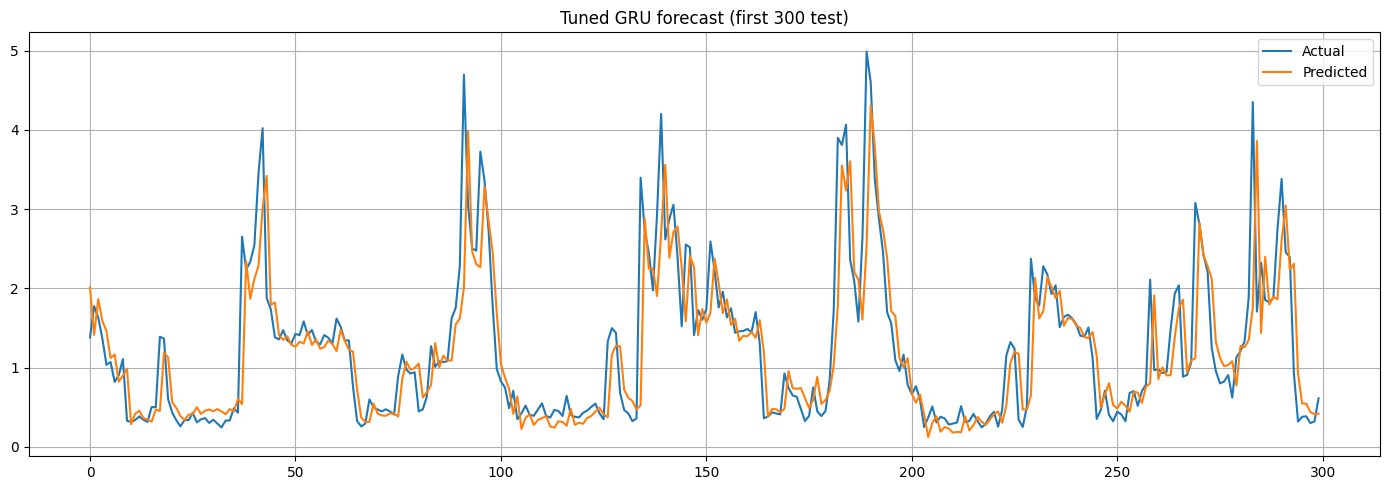

In [75]:
y_pred = best_model.predict(X_test)
y_pred_inv = scaler.inverse_transform(np.hstack((y_pred, X_test[:, -1, 1:])))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), X_test[:, -1, 1:])))[:, 0]

plt.figure(figsize=(14, 5))
plt.plot(y_test_inv[:300], label='Actual')
plt.plot(y_pred_inv[:300], label='Predicted')
plt.title("Tuned GRU forecast (first 300 test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [76]:
# last 24 time steps 
last_sequence = df_scaled[features].iloc[-24:].values
input_seq = last_sequence.reshape(1, 24, len(features))
# print(last_sequence)
# print(input_seq.shape)

future_preds = []

for _ in range(96):  
    pred = best_model.predict(input_seq)[0, 0]
    future_preds.append(pred)

    next_input = np.append(pred, input_seq[0, -1, 1:])  
    input_seq = np.append(input_seq[0, 1:], [next_input], axis=0).reshape(1, 24, len(features))


1/1 [==============================] - 0s 52ms/step


In [77]:
# dummy feature array for inverse_transform
preds_full = np.repeat(np.array(future_preds).reshape(-1, 1), len(features), axis=1)
preds_inverse = scaler.inverse_transform(preds_full)[:, 0]


In [78]:
import pandas as pd
import datetime

last_time = df['timestamp'].iloc[-1]
future_times = [last_time + datetime.timedelta(minutes=15 * i) for i in range(1, 97)]

future_gru_df = pd.DataFrame({
    'timestamp': future_times,
    'predicted_demand_kw': preds_inverse
})


C:\Users\nafeu\AppData\Local\Temp\ipykernel_10168\2161051255.py:21: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
d:\pyhton_project\Project\task_ml\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


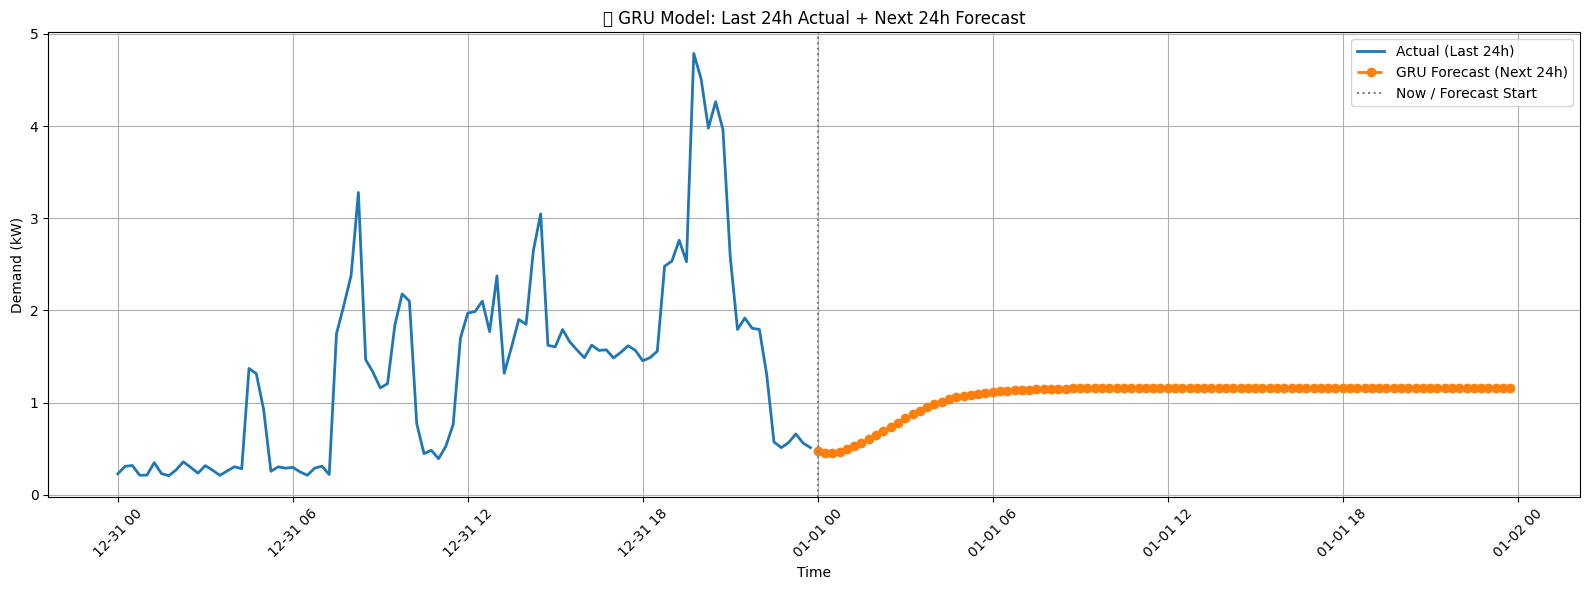

In [79]:
import matplotlib.pyplot as plt

actual_24h = df.tail(96)[['timestamp', 'demand_kw']].copy()
actual_24h.rename(columns={'demand_kw': 'actual_demand_kw'}, inplace=True)

combined = pd.concat([
    actual_24h[['timestamp', 'actual_demand_kw']],
    future_gru_df[['timestamp', 'predicted_demand_kw']]
], ignore_index=True)

plt.figure(figsize=(16, 6))
plt.plot(combined['timestamp'], combined['actual_demand_kw'], label='Actual (Last 24h)', linewidth=2)
plt.plot(combined['timestamp'], combined['predicted_demand_kw'], label='GRU Forecast (Next 24h)', linewidth=2, linestyle='--', marker='o')
plt.axvline(x=future_gru_df['timestamp'].iloc[0], color='gray', linestyle=':', label='Now / Forecast Start')
plt.title("🔮 GRU Model: Last 24h Actual + Next 24h Forecast")
plt.xlabel("Time")
plt.ylabel("Demand (kW)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\nafeu\AppData\Local\Temp\ipykernel_10168\2813479281.py:11: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
d:\pyhton_project\Project\task_ml\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


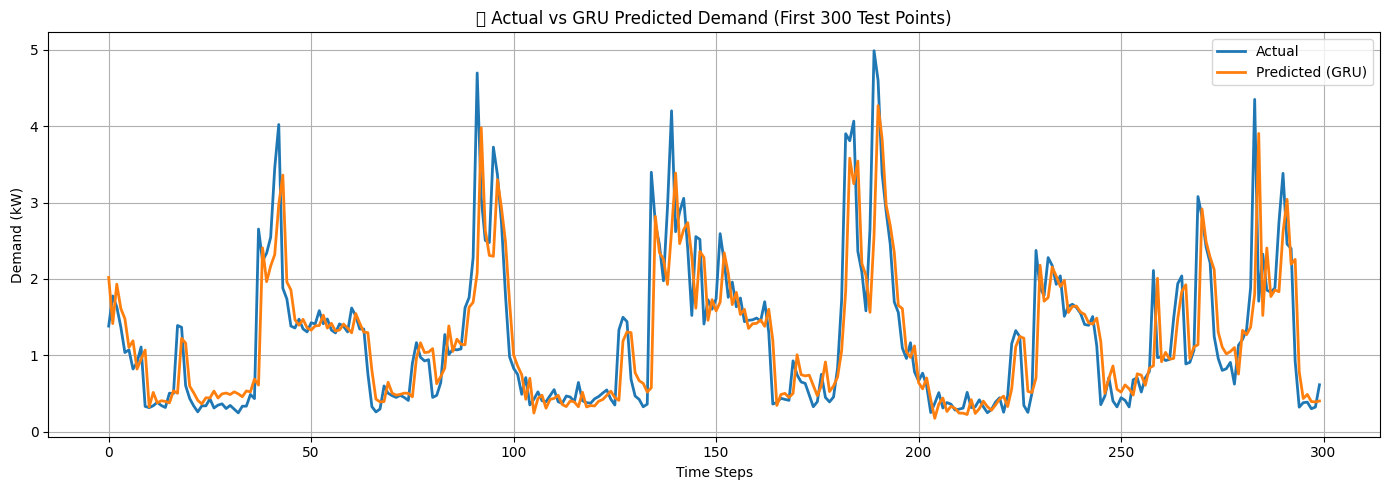

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test_inv[:300], label='Actual', linewidth=2)
plt.plot(y_pred_inv[:300], label='Predicted (GRU)', linewidth=2)
plt.title("🔍 Actual vs GRU Predicted Demand (First 300 Test Points)")
plt.xlabel("Time Steps")
plt.ylabel("Demand (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(units=64, layers=1, dropout=0.2):
    model = Sequential()
    for i in range(layers):
        return_seq = i < layers - 1
        model.add(LSTM(units=units, return_sequences=return_seq, dropout=dropout, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm_model()

history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    verbose=2
)


Epoch 1/20
395/395 - 14s - loss: 0.0032 - mae: 0.0386 - val_loss: 0.0023 - val_mae: 0.0325 - 14s/epoch - 34ms/step
Epoch 2/20
395/395 - 15s - loss: 0.0023 - mae: 0.0321 - val_loss: 0.0024 - val_mae: 0.0313 - 15s/epoch - 39ms/step
Epoch 3/20
395/395 - 23s - loss: 0.0023 - mae: 0.0323 - val_loss: 0.0022 - val_mae: 0.0310 - 23s/epoch - 58ms/step
Epoch 4/20
395/395 - 25s - loss: 0.0023 - mae: 0.0319 - val_loss: 0.0022 - val_mae: 0.0292 - 25s/epoch - 63ms/step
Epoch 5/20
395/395 - 32s - loss: 0.0023 - mae: 0.0321 - val_loss: 0.0021 - val_mae: 0.0321 - 32s/epoch - 80ms/step
Epoch 6/20
395/395 - 23s - loss: 0.0022 - mae: 0.0314 - val_loss: 0.0021 - val_mae: 0.0305 - 23s/epoch - 59ms/step
Epoch 7/20
395/395 - 23s - loss: 0.0023 - mae: 0.0316 - val_loss: 0.0022 - val_mae: 0.0300 - 23s/epoch - 59ms/step
Epoch 8/20
395/395 - 23s - loss: 0.0023 - mae: 0.0317 - val_loss: 0.0020 - val_mae: 0.0286 - 23s/epoch - 58ms/step
Epoch 9/20
395/395 - 23s - loss: 0.0022 - mae: 0.0314 - val_loss: 0.0021 - val_m

220/220 [==============================] - 3s 10ms/step
 LSTM model evaluation:
MAE          : 0.4274
RMSE         : 0.6291
R squared    : 0.6513


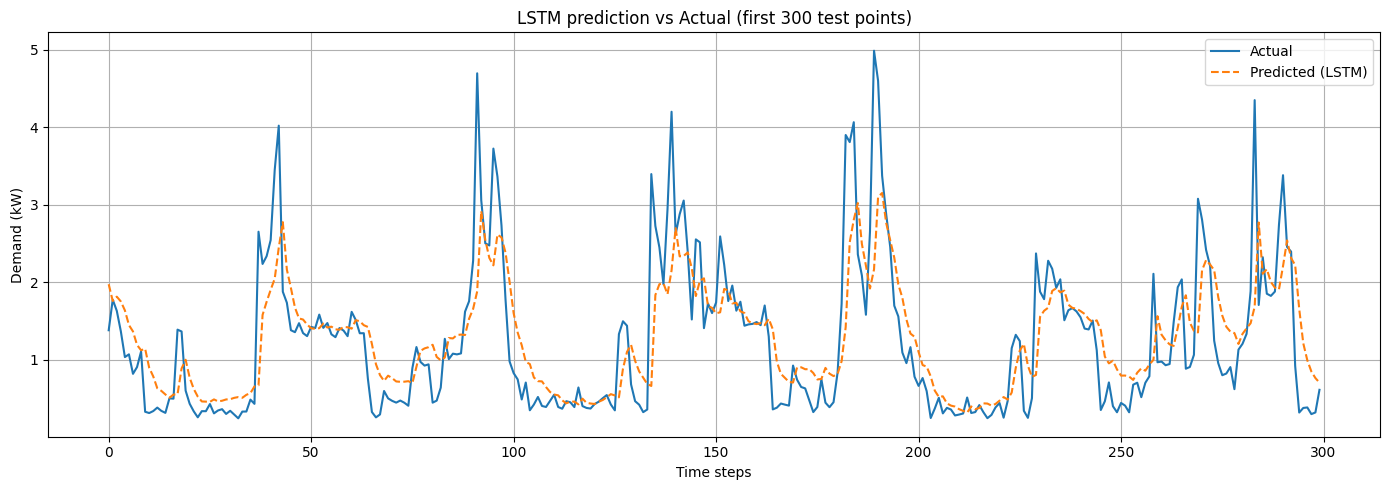

In [81]:
y_pred_lstm_scaled = lstm_model.predict(X_test)

y_pred_lstm_inv = scaler.inverse_transform(np.hstack((y_pred_lstm_scaled, X_test[:, -1, 1:])))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), X_test[:, -1, 1:])))[:, 0]

mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))
r2_lstm = r2_score(y_test_inv, y_pred_lstm_inv)

print(" LSTM model evaluation:")
print(f"MAE          : {mae_lstm:.4f}")
print(f"RMSE         : {rmse_lstm:.4f}")
print(f"R squared    : {r2_lstm:.4f}")

plt.figure(figsize=(14, 5))
plt.plot(y_test_inv[:300], label='Actual')
plt.plot(y_pred_lstm_inv[:300], label='Predicted (LSTM)', linestyle='--')
plt.title("LSTM prediction vs Actual (first 300 test points)")
plt.xlabel("Time steps")
plt.ylabel("Demand (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

# (multivariate)
features = ['demand_kw', 'temperature_celsius', 'humidity_percent', 'voltage_mean']
data = df[features].copy()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

seq_len = 96 

X, y = [], []
for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i, 0])  # predicting demand_kw

X, y = np.array(X), np.array(y)

split = int(len(X) * 0.9)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

model = Sequential()
model.add(GRU(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop], verbose=1)

y_pred = model.predict(X_val)
y_pred_inv = scaler.inverse_transform(np.concatenate([y_pred,X_val[:, -1, 1:]], axis=1))[:, 0]  # only demand_kw
y_val_inv = scaler.inverse_transform(np.concatenate([y_val.reshape(-1, 1),X_val[:, -1, 1:]], axis=1))[:, 0]


plt.figure(figsize=(14, 5))
plt.plot(y_val_inv[:300], label='Actual', linewidth=2)
plt.plot(y_pred_inv[:300], label='Predicted', linewidth=2)
plt.title('GRU Forecast - Last 10% Test Set')
plt.xlabel('Time Step')
plt.ylabel('Demand (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/10
985/985 [==============================] - 150s 150ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 2/10
 80/985 [=>............................] - ETA: 4:06 - loss: 0.0016

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_val_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
r2 = r2_score(y_val_inv, y_pred_inv)

print(" GRU")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R squared   : {r2:.4f}")


 GRU
MAE  : 0.3269
RMSE : 0.5619
R squared   : 0.7020


1/1 [==============================] - 0s 16ms/step


C:\Users\nafeu\AppData\Local\Temp\ipykernel_10168\1428154561.py:33: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
d:\pyhton_project\Project\task_ml\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


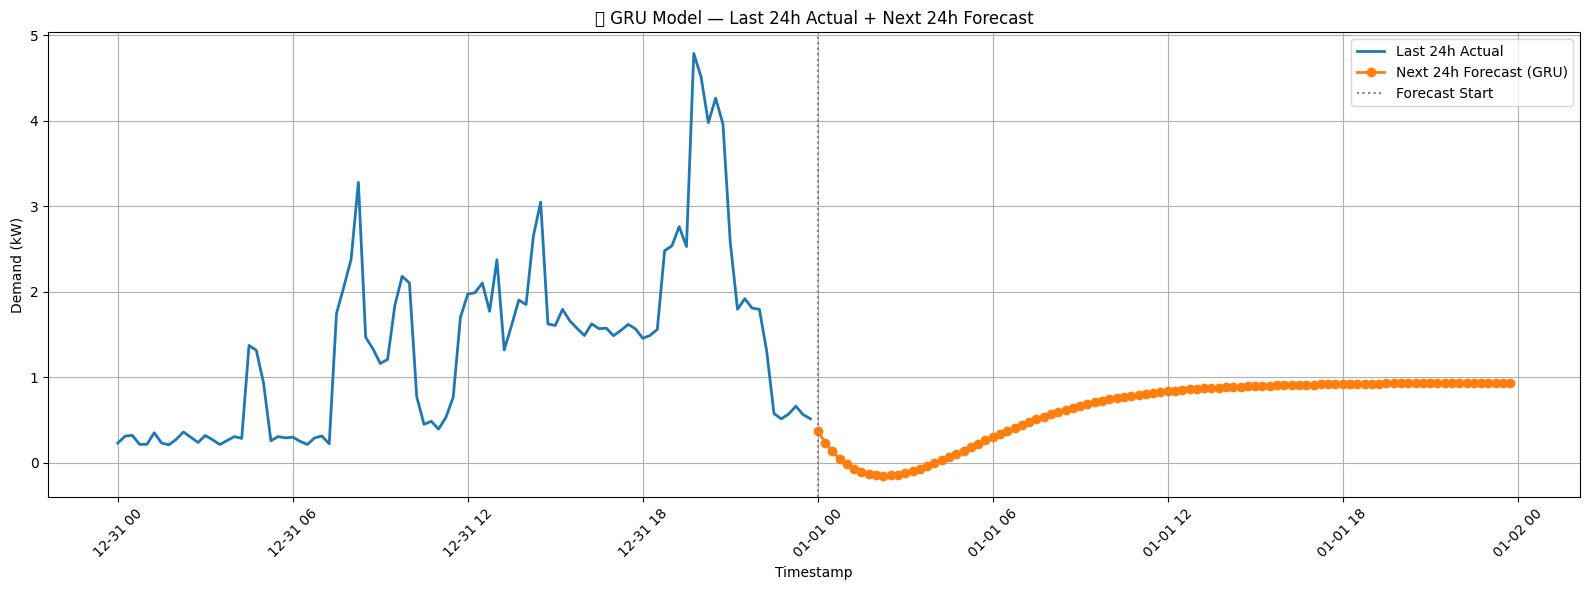

In [ ]:
last_seq = scaled_data[-96:].copy()
future_inputs = list(last_seq)

future_predictions = []

for _ in range(96):  
    input_array = np.array(future_inputs[-96:]).reshape(1, 96, len(features))
    next_scaled = model.predict(input_array)[0, 0] 

    #latest exogenous features (temperature, humidity, voltage) from last known row
    latest_exog = future_inputs[-1][1:]  # exclude demand_kw
    next_input = np.concatenate([[next_scaled], latest_exog])

    future_inputs.append(next_input)
    future_predictions.append(next_input)

future_predictions = np.array(future_predictions)
inv_future = scaler.inverse_transform(future_predictions)[:, 0]  # demand_kw only

last_time = df['timestamp'].iloc[-1]
future_times = [last_time + pd.Timedelta(minutes=15 * i) for i in range(1, 97)]

plt.figure(figsize=(16, 6))
plt.plot(df['timestamp'].iloc[-96:], df['demand_kw'].iloc[-96:], label='Last 24h Actual', linewidth=2)
plt.plot(future_times, inv_future, label='Next 24h Forecast (GRU)', linewidth=2, marker='o')
plt.axvline(x=future_times[0], color='gray', linestyle=':', label='Forecast Start')
plt.title("🔮 GRU Model — Last 24h Actual + Next 24h Forecast")
plt.xlabel("Timestamp")
plt.ylabel("Demand (kW)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
